In [246]:
import numpy as np
import pandas as pd
import os
import csv

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn.naive_bayes import GaussianNB, MultinomialNB

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
import scikitplot as skplt
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import warnings


#  Data files

In [248]:
data_folder_path = "data/ARem/"
data_folders = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
cols = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

# Train Test Files split

In [249]:
def train_test_split(data_folder_path,data_folders,cols):
    test_files_path,train_files_path = [],[]
    for folder in data_folders:
        path = os.path.join(os.getcwd(),data_folder_path, folder)
        files = os.listdir(path)
        test_size = 2 if folder =="bending1" or folder == "bending2" else 3 
        
        test_files_path.append([os.path.join(path,file).replace("\\","/") for file in files[:test_size]])
        train_files_path.append([os.path.join(path,file).replace("\\","/") for file in files[test_size:]])
        
    return test_files_path,train_files_path

In [250]:
test_files_path,train_files_path = train_test_split(data_folder_path,data_folders,cols)

#  Extract Time-Domain Features
References: https://stackoverflow.com/questions/48420684/appending-arrays-to-dataframe-python

https://stackoverflow.com/questions/47736022/convert-a-pandas-dataframe-into-a-single-row-dataframe

In [251]:
def get_stats(data,req_cols,all_cols,file,div=1):
    data.drop(['time'], axis=1, inplace=True)    
        
    seg_len = int(data.shape[0] / div)
    seg_stats = []
    for i in range(div):
        data_seg = data[i * seg_len : min((i + 1) * seg_len, data.shape[0])]
        data_stat = data_seg.describe().drop('count')
        data_stat.rename(index={'50%':'median','25%':'1st_quart','75%':'3rd_quart',},inplace=True)         
        data_stat = data_stat.reindex(req_cols)
        df = data_stat.T
        df.index = [i for i in range(1, 7)]
        df_row = df.stack()
        df_row.index = df_row.index.map('{0[1]}{0[0]}'.format)
        for val in df_row.values:
            seg_stats.append(val)
        
    seg_stats.append(file.split('/')[-2])
    return seg_stats

In [252]:
def get_features(file,sniffer,reqd_stats,all_cols,div,std=False):
        sep = sniffer.sniff(open(file).read()).delimiter
        if sep ==",":
            data = pd.read_csv(file,sep=sep,skiprows =5,names=cols)#,error_bad_lines=False, warn_bad_lines=False)
        else:
            data = pd.read_csv(file,sep="\s+",skiprows =5,names=cols)#,error_bad_lines=False, warn_bad_lines=False)
        return get_stats(data,reqd_stats,all_cols,file,div)

In [253]:
def gen_train_test_full_DF(reqd_stats,div=1,imbalance=False):   
    all_cols = [stat +str(i) for i in range(1, (div*6)+1) for stat in reqd_stats]
    all_cols.append('activity_label')
    time_series_DF = pd.DataFrame(columns=all_cols)
    rows_train = []
    rows_test = []
    sniffer = csv.Sniffer()
    for i in range(len(data_folders)):      
        for file in train_files_path[i]:
             rows_train.append(get_features(file,sniffer,reqd_stats,all_cols,div))       
        for file in test_files_path[i]:
            rows_test.append(get_features(file,sniffer,reqd_stats,all_cols,div))        
    train = pd.DataFrame(rows_train,columns=all_cols)
    test = pd.DataFrame(rows_test,columns=all_cols)
    DF = test.append(train, ignore_index=True)
    return train,test,DF

In [254]:
reqd_stats = ['min', 'max', 'mean', 'median', 'std','1st_quart','3rd_quart']
time_series_train,time_series_test,time_series_DF = gen_train_test_full_DF(reqd_stats,1)

#  Std Dev and Bootstrap

In [255]:
std_data = time_series_train.describe().loc['std']

In [256]:
#Bootstrap
i=0
for col in time_series_train.columns[:-1]:
    res = bs.bootstrap(time_series_train[col].to_numpy(), stat_func=bs_stats.std)    
    diff = std_data[i] - res
    print(col,"Actual std:",std_data[i],"Bootstrap results:",res,"Difference:",diff,"\n",)
    i+=1

min1 Actual std: 9.251537650127712 Bootstrap results: 9.184252846969526    (7.711453849505819, 10.667312999188034) Difference: 0.06728480315818608    (-1.415775349060322, 1.5400838006218933) 

max1 Actual std: 3.980197835307203 Bootstrap results: 3.951250557783494    (2.8453984856824146, 5.1695506686783546) Difference: 0.02894727752370896    (-1.1893528333711516, 1.1347993496247883) 

mean1 Actual std: 4.8431582655744805 Bootstrap results: 4.807934828899753    (4.2309912250121675, 5.439945340822111) Difference: 0.035223436674727715    (-0.5967870752476303, 0.612167040562313) 

median1 Actual std: 4.969356204475235 Bootstrap results: 4.933214952427646    (4.331517157392299, 5.624711321190801) Difference: 0.03614125204758967    (-0.6553551167155653, 0.6378390470829363) 

std1 Actual std: 1.876742136003761 Bootstrap results: 1.8630929211407652    (1.6205858958855033, 2.1345321387328866) Difference: 0.013649214862995862    (-0.25779000272912556, 0.25615624011825777) 

1st_quart1 Actual std

#  Most-imp time domain features

In [257]:
most_imp_features = ['min', 'std', '1st_quart']

Features having standard deviation closest to bootstrap results can be considered important time domain features

# Scatter plot for important features

In [258]:
def plot_bending(time_series_train,sel_features,cols):
    bending_bin_train = pd.DataFrame(time_series_train)
    bending_bin_train['activity_label'] = np.where(bending_bin_train['activity_label'].isin(["bending1","bending2"]), "1", "0")
    features = [feat + str(i) for i in cols for feat in sel_features]
    features.append('activity_label')
    df = bending_bin_train[features]
    plt.figure(figsize=(6,12))
    sns.pairplot(df,hue='activity_label')
    
    plt.show()

<Figure size 432x864 with 0 Axes>

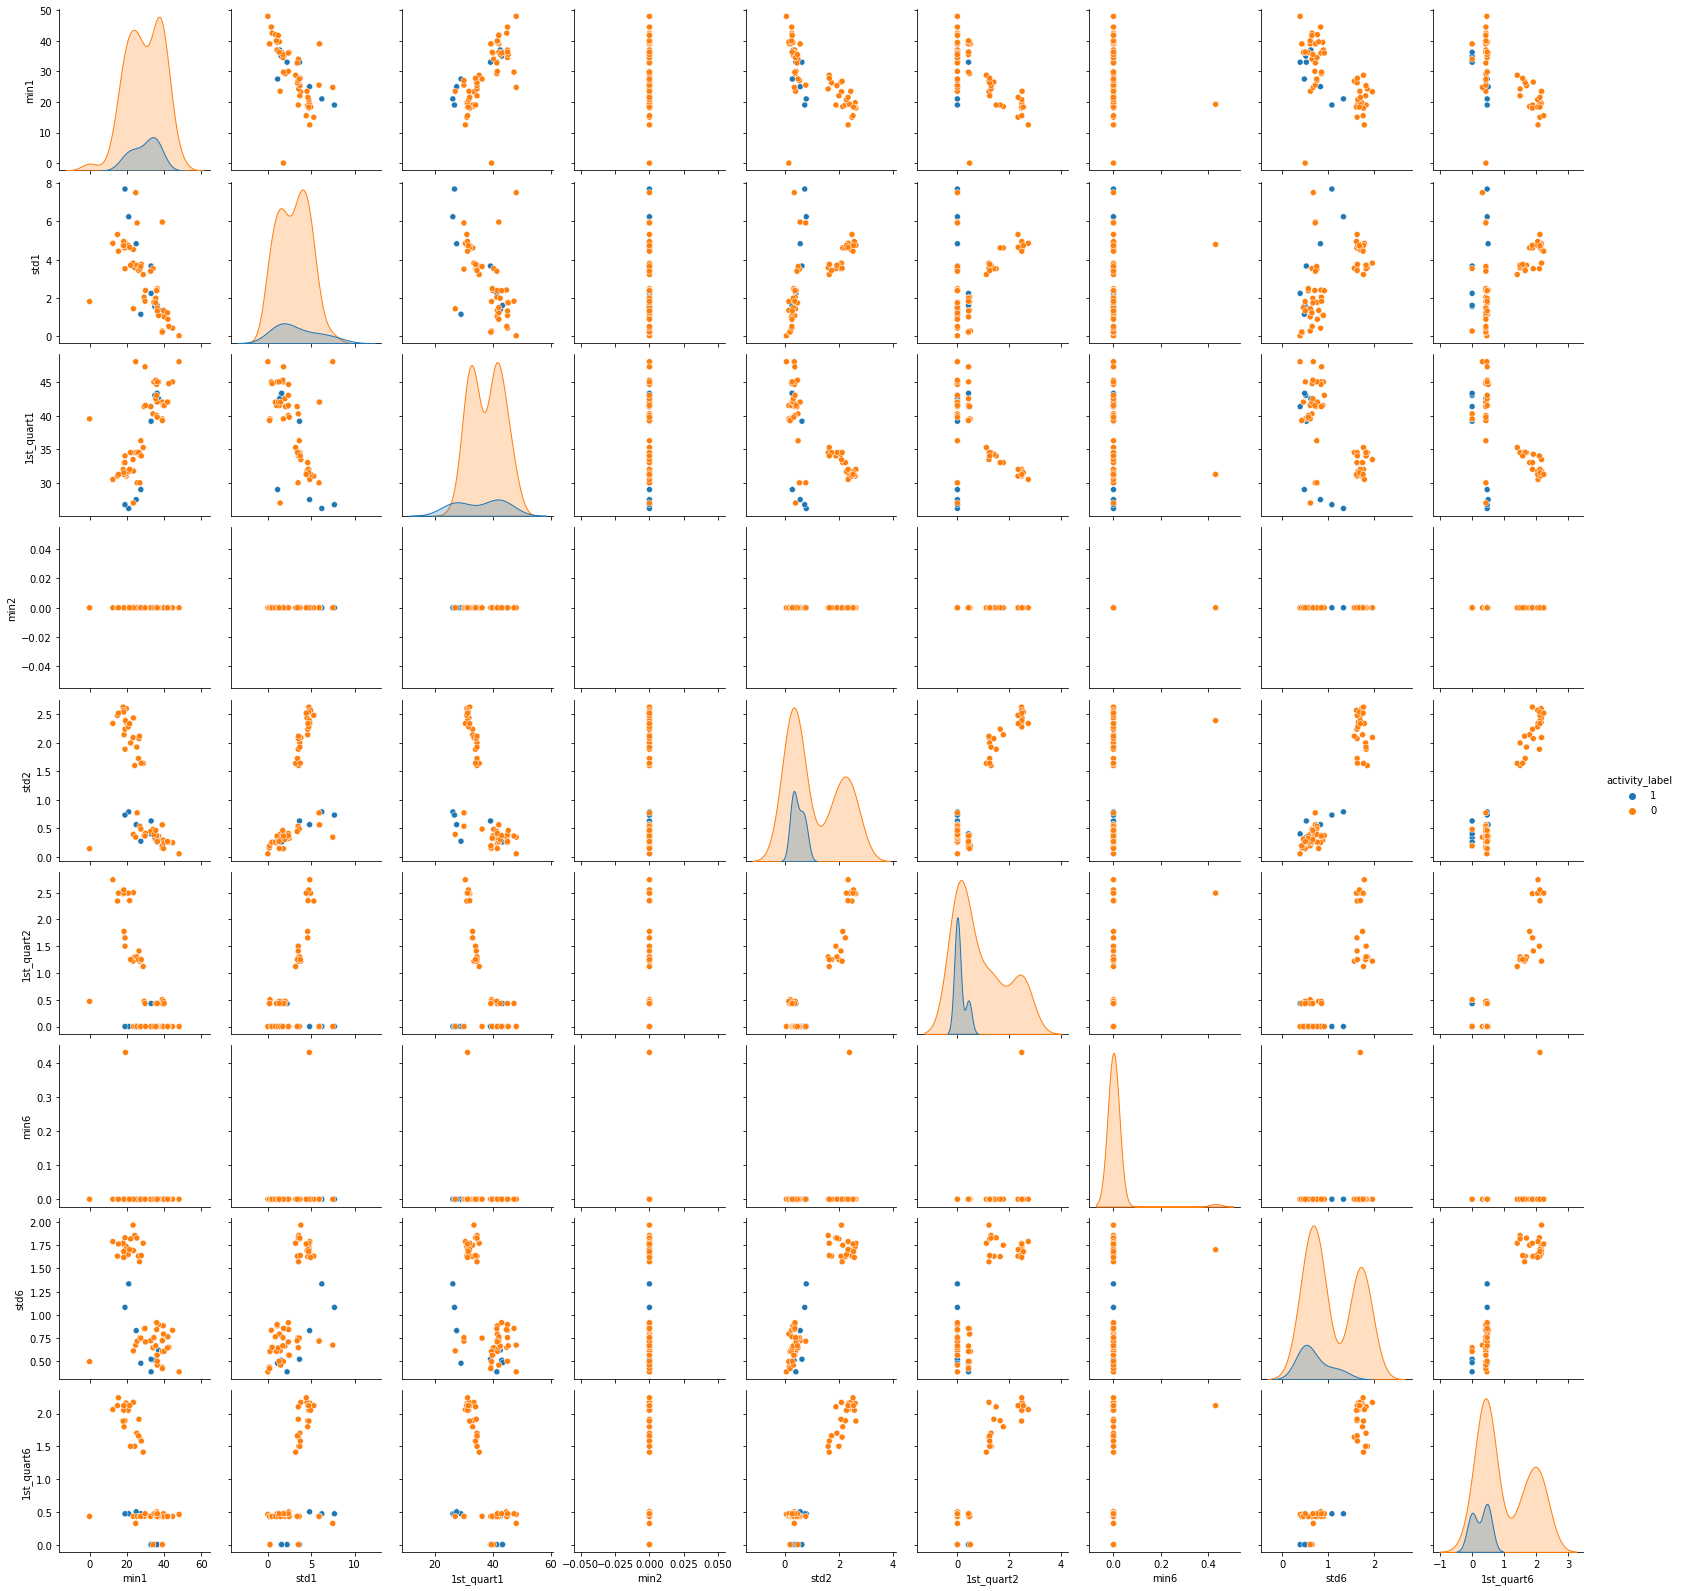

In [259]:
sel_cols = [1,2,6]
plot_bending(time_series_train,most_imp_features,sel_cols)

#  Break time series into 2 parts

<Figure size 432x864 with 0 Axes>

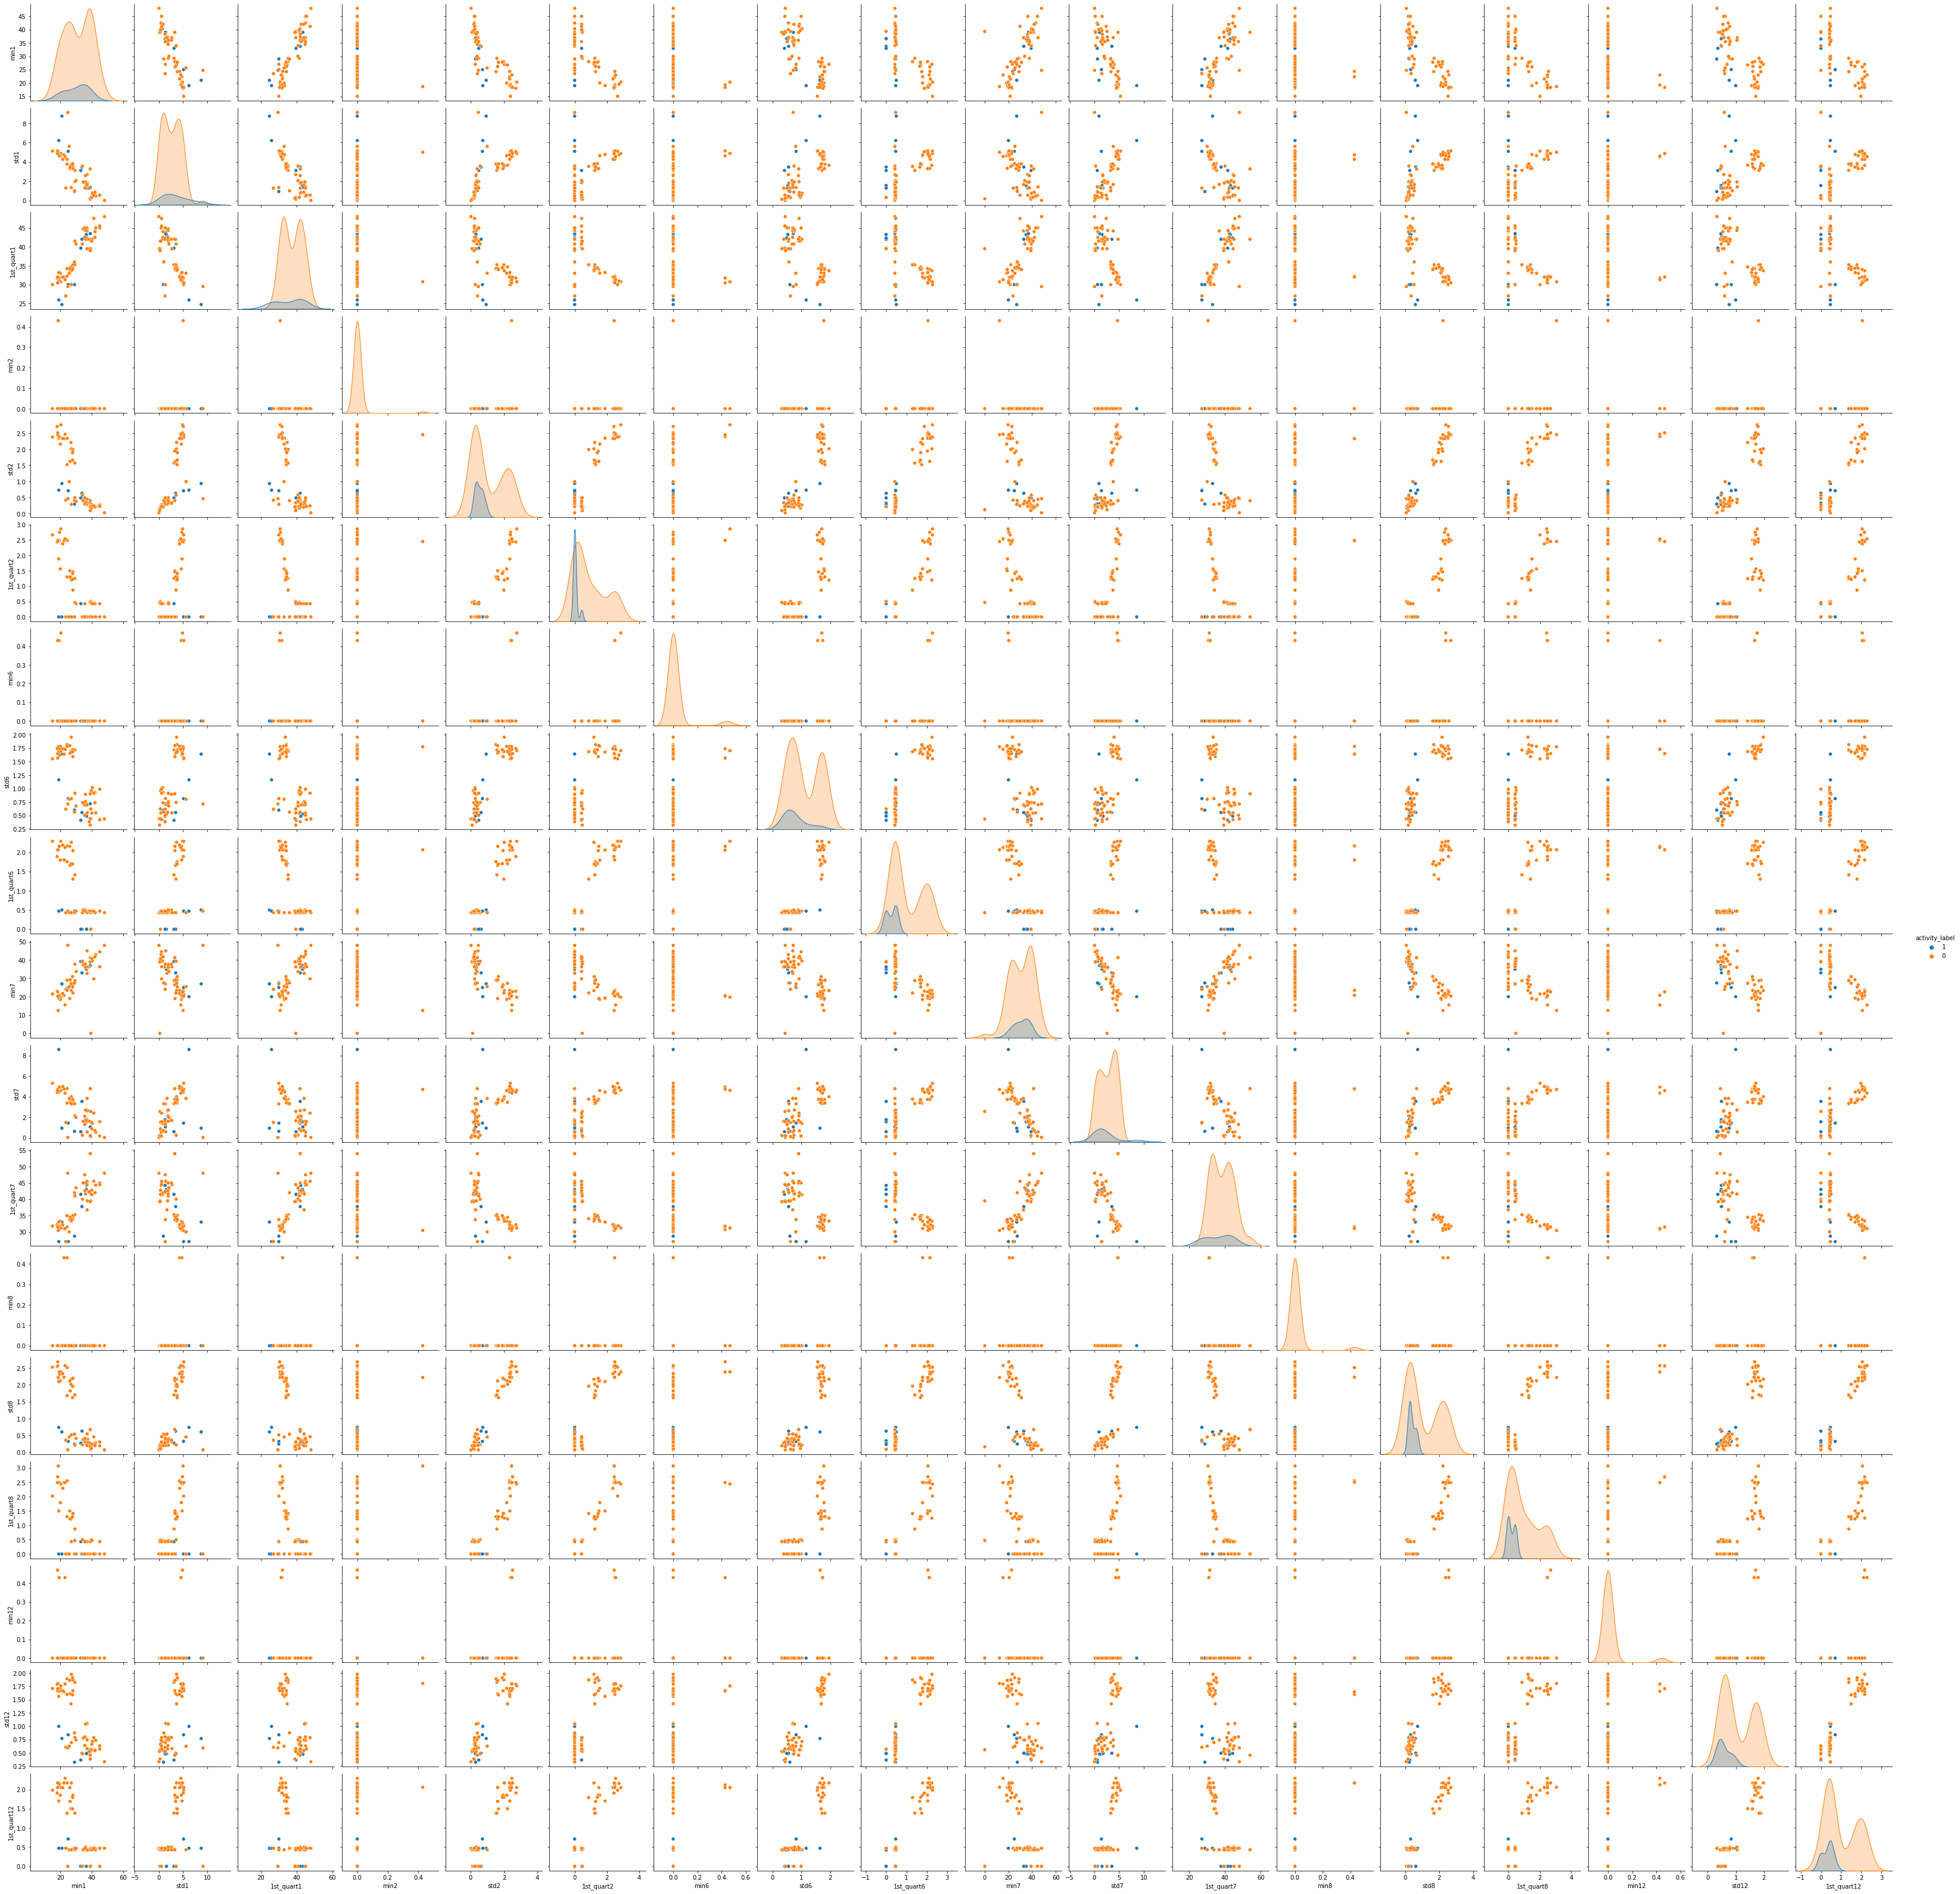

In [260]:
reqd_stats = ['min', 'max', 'mean', 'median', 'std','1st_quart','3rd_quart']
time_series_train_2,time_series_test_2,time_series_DF_2 = gen_train_test_full_DF(reqd_stats,2)
sel_cols = [1,2,6,7,8,12]
plot_bending(time_series_train_2,most_imp_features,sel_cols)

Previously we divided the data into 2 equal halves thus each half will have much lesser data compared to the original data.
But I notice that the pair plots of the divided time-series data follows similar trend compared to the undivided data

#  Logistic Regression: Break time series into l∈{1,..20} parts
https://stackoverflow.com/questions/67971394/rfecv-for-feature-selection-for-logisticregression-adaboostclassifier-randomfo
https://stackoverflow.com/questions/31059123/scikit-learn-feature-reduction-using-rfecv-and-gridsearch-where-are-the-coeff

In [261]:
flatten = lambda *n: (e for a in n
    for e in (flatten(*a) if isinstance(a, (tuple, list)) else (a,)))

In [262]:
def get_only_reqd_features(X):    
    features=[]
    #for ft in most_imp_features:
    #        features.append([val for val in X.columns if ft in val])
            
    for val in X.columns:
        for ft in most_imp_features:
            if ft in val: features.append(val)
                
    X_reqd = X.loc[:,flatten(features)]
    return X_reqd

In [263]:
def get_LR_K_Fold(reqd_stats,n):
    acc_vals = []
    num_ftrs = []
    l_vals = []
    for l in range(1,n+1):
        time_series_train_l,time_series_test_l,time_series_DF_l = gen_train_test_full_DF(reqd_stats,l)
        bending_bin_train_l = pd.DataFrame(time_series_train_l)
        time_series_train_l['activity_label'] = np.where(time_series_train_l['activity_label'].\
                                                         isin(["bending1","bending2"]),"1", "0")
        
               
        X_train = get_only_reqd_features(time_series_train_l)
        y_train = time_series_train_l.iloc[:,-1]
        
        k_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        estimator_LR = LogisticRegression(random_state=42,max_iter=100,penalty='none')
        selector_LR = RFECV(estimator_LR, cv=k_cv,scoring='accuracy')
        selector_LR.fit(X_train, y_train)
        acc_vals.append(max(selector_LR.grid_scores_))
        num_ftrs.append(selector_LR.n_features_)
        l_vals.append(l)
        print(l,max(selector_LR.grid_scores_),selector_LR.n_features_)
    LR_results = pd.DataFrame({"l":l_vals,"Accuracy":acc_vals,"Number of features":num_ftrs})
    
    print(LR_results)

In [264]:
reqd_stats = ['min', 'max', 'mean', 'median', 'std','1st_quart','3rd_quart']
n=20
get_LR_K_Fold(reqd_stats,n)

1 0.9428571428571428 10
2 0.9274725274725275 15
3 0.9560439560439562 7
4 0.9428571428571428 24
5 0.9417582417582417 1
6 0.9428571428571428 1
7 0.9417582417582417 21
8 0.9285714285714285 1
9 0.9417582417582417 4
10 0.9417582417582417 49
11 0.9846153846153847 4
12 0.9714285714285715 26
13 0.9846153846153847 7
14 0.9703296703296704 5
15 0.9846153846153847 7
16 1.0 8
17 0.9857142857142858 12
18 1.0 7
19 1.0 7
20 1.0 13
     l  Accuracy  Number of features
0    1  0.942857                  10
1    2  0.927473                  15
2    3  0.956044                   7
3    4  0.942857                  24
4    5  0.941758                   1
5    6  0.942857                   1
6    7  0.941758                  21
7    8  0.928571                   1
8    9  0.941758                   4
9   10  0.941758                  49
10  11  0.984615                   4
11  12  0.971429                  26
12  13  0.984615                   7
13  14  0.970330                   5
14  15  0.984615          

Since L=16 has a train score of 1.0, 16 will be chosen for the calculations below

# Reporting the confusion matrix and  ROC and AUC for the classifier on train data. Reporting the parameters of logistic regression  𝛽𝑖 ’s as well as the p-values associated with them.

https://stackoverflow.com/questions/56165951/maximum-number-of-iterations-has-been-exceeded-in-logistic-regression
https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [265]:
def get_cm_roc_auc(selector_LR,sel_features,imp_features,time_series_train_1):
    X_train = time_series_train_1.loc[:,sel_features]
    y_train = time_series_train_1.loc[:,'activity_label']
    selector_LR.fit(X_train,y_train)
    predict = selector_LR.predict(X_train)
    cm=confusion_matrix(y_train,predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);
    plt.show()
    
    prob = selector_LR.predict_proba(X_train)    
    fpr, tpr, threshold = roc_curve(y_train.to_numpy(dtype="int"), prob[:, 1])    
    roc_auc = auc(fpr, tpr)    
    plt.plot(fpr, tpr, 'b', label='AUC ='+str(roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return selector_LR
    

In [266]:
def get_LR_stats(X_train,y_train,sel_features):
    X2 = sm.add_constant(X_train.loc[:,sel_features].to_numpy(dtype=float))
    log_reg = sm.Logit(y_train.to_numpy(dtype=float), X2).fit(method='bfgs')
    print(log_reg.summary())
    

In [267]:
def get_LR_Opti(reqd_stats):
    acc_vals = []
    num_ftrs = []
    l_vals = []
    all_cols = [stat +str(i) for i in range(1, (16*6)+1) for stat in reqd_stats]
    time_series_train_1,time_series_test_1,time_series_DF_1 = gen_train_test_full_DF(reqd_stats,16)
    bending_bin_train_1 = pd.DataFrame(time_series_train_1)
    time_series_train_1['activity_label'] = np.where(time_series_train_1['activity_label'].\
                                                     isin(["bending1","bending2"]),"1", "0")

    X_train = get_only_reqd_features(time_series_train_1)
    y_train = time_series_train_1.iloc[:,-1]
    
    k_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    estimator_LR = LogisticRegression(random_state=42, solver='lbfgs',max_iter=100,penalty='none')
    selector_LR = RFECV(estimator_LR, cv=k_cv,scoring='accuracy')
    selector_LR.fit(X_train, y_train)
    
    imp_features = selector_LR.get_support(indices=True)
    
    sel_features = [X_train.columns[i] for i in imp_features]
    print("The selected features are:",sel_features)  
    get_LR_stats(X_train,y_train,sel_features)
    selector_LR = get_cm_roc_auc(selector_LR,sel_features,imp_features,time_series_train_1)
    
    return selector_LR,time_series_train_1,time_series_test_1,sel_features

The selected features are: ['min11', '1st_quart11', 'min17', 'min29', '1st_quart49', '1st_quart55', '1st_quart73', 'min83']
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       60
Method:                           MLE   Df Model:                            8
Date:                Fri, 08 Oct 2021   Pseudo R-squ.:                   1.000
Time:                        20:39:25   Log-Likelihood:            -1.1091e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 8.882e-09
                 coef    std err          z      P>|z|      [0.025      

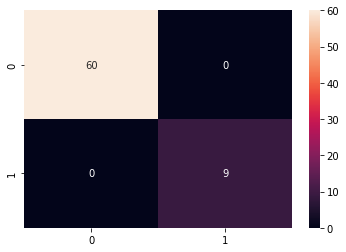

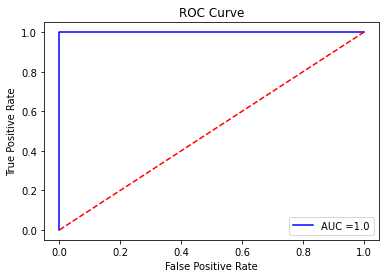

In [268]:
reqd_stats = ['min', 'max', 'mean', 'median', 'std','1st_quart','3rd_quart']
selector_LR,time_series_train_1,time_series_test_1,sel_features = get_LR_Opti(reqd_stats)



# Testing the classifier on the test set

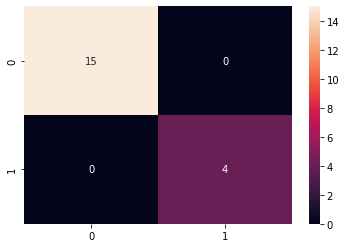

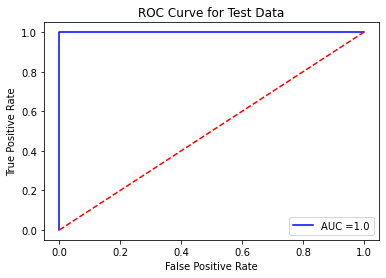

In [269]:
time_series_test_1['activity_label'] = np.where(time_series_test_1['activity_label'].\
                                                     isin(["bending1","bending2"]),"1", "0")
X_test = time_series_test_1.loc[:,sel_features]
#X_test = get_only_reqd_features(time_series_test_1)
y_test = time_series_test_1.loc[:,'activity_label']


predict = selector_LR.predict(X_test)
cm=confusion_matrix(y_test,predict)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
plt.show()

prob = selector_LR.predict_proba(X_test)  


fpr, tpr, threshold = roc_curve(y_test.to_numpy(dtype="int"), prob[:, 1])  
roc_auc = auc(fpr, tpr)    
plt.plot(fpr, tpr, 'b', label ='AUC ='+str(roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Test Data')
plt.show()

Both test accuracy and cross_validation accuracy is 100% since the model is able to predict all TPs and FPs

The classes seem to be well-seperated since all are FPs or TPs. Also the logit model says "Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified"

The classes are highly imbalanced, in the training set there are only 9 instances of "bending" class 
but 60 instances of other class.

In [270]:
def get_undersample_cm_roc_auc(selector_LR,sel_features,imp_features,X_under,y_under):
    X_train = X_under.loc[:,sel_features]
    y_train = y_under
    
    selector_LR.fit(X_train,y_train)
    predict = selector_LR.predict(X_train)
    cm=confusion_matrix(y_train,predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);
    plt.show()
    
    prob = selector_LR.predict_proba(X_train)    
    fpr, tpr, threshold = roc_curve(y_train.to_numpy(dtype="int"), prob[:, 1],pos_label=1) 
    roc_auc = auc(fpr, tpr)    
    plt.plot(fpr, tpr, 'b', label='AUC ='+str(roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return selector_LR
    

In [271]:
def get_undersample_LR_stats(X_train,y_train,sel_features):
    X2 = sm.add_constant(X_train.loc[:,sel_features].to_numpy(dtype=float))
    log_reg = sm.Logit(y_train.to_numpy(dtype=float), X2).fit(method='bfgs')
    print(log_reg.summary())
    

In [272]:
def get_undersample_LR(time_series_train_1,all_cols):
    X_train = get_only_reqd_features(time_series_train_1)
    y_train = time_series_train_1.iloc[:,-1]

    undersample = RandomUnderSampler(sampling_strategy={
                                                "0": y_train.value_counts()[1]*3,
                                                "1": y_train.value_counts()[1]
                                                        },random_state=42)
    
    X_under, y_under = undersample.fit_resample(X_train, y_train)
    k_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    estimator_LR = LogisticRegression(random_state=42, solver='lbfgs',max_iter=100,penalty='none')
    selector_LR = RFECV(estimator_LR, cv=k_cv,scoring='accuracy')
    selector_LR.fit(X_under, y_under)
    
    imp_features = selector_LR.get_support(indices=True)
    
    sel_features = [X_train.columns[i] for i in imp_features]
    print("The selected features are:",sel_features)
    get_undersample_LR_stats(X_under,y_under,sel_features)
    selector_LR = get_undersample_cm_roc_auc(selector_LR,sel_features,imp_features,X_under,y_under)
         
    return selector_LR,sel_features

The selected features are: ['std1', 'std2', '1st_quart2', '1st_quart4', 'std5', '1st_quart6']
         Current function value: 0.221539
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   36
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                            6
Date:                Fri, 08 Oct 2021   Pseudo R-squ.:                  0.6060
Time:                        20:39:29   Log-Likelihood:                -7.9754
converged:                      False   LL-Null:                       -20.244
Covariance Type:            nonrobust   LLR p-value:                 0.0004158
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

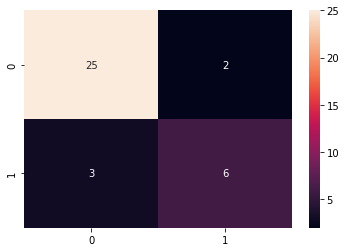

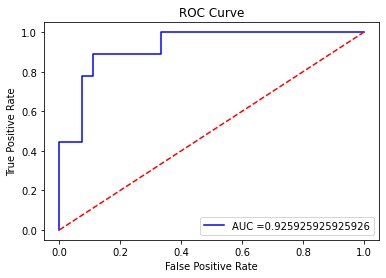

In [273]:
#selector_LR,time_series_train_1,time_series_test_1,sel_features
all_cols = [stat +str(i) for i in range(1, 7) for stat in reqd_stats]
time_series_train_1,time_series_test_1,time_series_DF_1 = gen_train_test_full_DF(reqd_stats,1)
time_series_train_1['activity_label'] = np.where(time_series_train_1['activity_label'].\
                                                     isin(["bending1","bending2"]),"1", "0")
selector_LR,sel_features = get_undersample_LR(time_series_train_1,all_cols)   

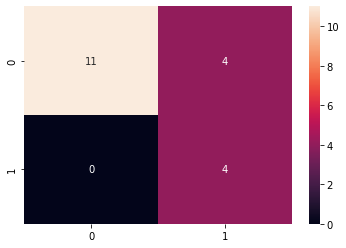

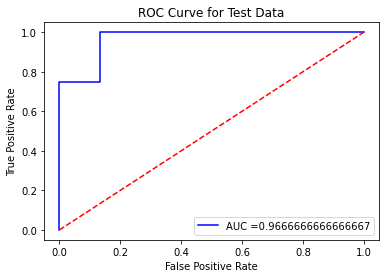

In [274]:
time_series_train_1,time_series_test_1,time_series_DF_1 = gen_train_test_full_DF(reqd_stats,1)
time_series_test_1['activity_label'] = np.where(time_series_test_1['activity_label'].\
                                                     isin(["bending1","bending2"]),"1", "0")
X_test = time_series_test_1.loc[:,sel_features]
y_test = time_series_test_1.loc[:,'activity_label']

predict = selector_LR.predict(X_test)
cm=confusion_matrix(y_test,predict)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
plt.show()

prob = selector_LR.predict_proba(X_test)  


fpr, tpr, threshold = roc_curve(y_test.to_numpy(dtype="int"), prob[:, 1],pos_label=1)  
roc_auc = auc(fpr, tpr)       
plt.plot(fpr, tpr, 'b', label ='AUC ='+str(roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Test Data')
plt.show()

In [ ]:
On using case-control sampling where I have undersampled to 1:3 ratio, there are higher miscalculations comparatively but
the features have lower p-values.

# Binary Classification Using L1-penalized logistic regression

In [275]:
def get_LR_L1_penalized(reqd_stats,n,solv,LR=True,binary = True,Gaus=False,NB=False):
    train_accs= []
    test_accs= []
    l_vals = []
    print("l","\t","Train accuracy","\t","Test Accuracy")
    for l in range(1,n+1):
        time_series_train_l,time_series_test_l,time_series_DF_l = gen_train_test_full_DF(reqd_stats,l)
        if binary==True:
            time_series_train_l['activity_label'] = np.where(time_series_train_l['activity_label'].\
                                                         isin(["bending1","bending2"]),"1", "0")
            time_series_test_l['activity_label'] = np.where(time_series_test_l['activity_label'].\
                                                         isin(["bending1","bending2"]),"1", "0")
        else:
            time_series_train_l['activity_label'] = time_series_train_l['activity_label'].astype('category')
            time_series_test_l['activity_label'] = time_series_test_l['activity_label'].astype('category')
        
               
        X_train = get_only_reqd_features(time_series_train_l)
        #X_train = time_series_train_l.iloc[:,:-1]
        y_train = time_series_train_l.iloc[:,-1]
        
        X_test = get_only_reqd_features(time_series_test_l)
        #X_test = time_series_test_l.iloc[:,:-1]
        y_test = time_series_test_l.iloc[:,-1]
        if LR == True:
            if binary==True:
                selector_LR = LogisticRegressionCV(random_state=42,cv=5, solver=solv,max_iter=100,\
                                               penalty='l1',scoring='accuracy')
            else:
                selector_LR = LogisticRegressionCV(random_state=42,cv=5, solver=solv,multi_class='multinomial',\
                                                   max_iter=100,penalty='l1',scoring='accuracy')
        if Gaus == True:
            selector_LR = GaussianNB()
            
        if NB == True:
            selector_LR = MultinomialNB()
            

        selector_LR.fit(X_train, y_train)
        train_acc = selector_LR.score(X_train, y_train)
        test_acc = selector_LR.score(X_test, y_test)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        l_vals.append(l)
        print(l,train_acc,test_acc)
    LR_results = pd.DataFrame({"l":l_vals,"Train Score":train_accs,"Test Score":test_accs})
    
    print(LR_results)

In [276]:
def get_cm_roc_auc_L1(X,Y,predict,prob,binary=True):
    cm=confusion_matrix(Y,predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);
    plt.show()
    
    if binary==True:         
        fpr, tpr, threshold = roc_curve(Y.to_numpy(dtype="int"), prob[:, 1],pos_label=1)
        roc_auc = auc(fpr, tpr)    
        plt.plot(fpr, tpr, 'b', label ='AUC ='+str(roc_auc))
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
    else:
        skplt.metrics.plot_roc_curve(Y, prob)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [277]:
def opti_L(l,solv,LR=True,binary = True,Gaus=False,NB=False):
    le = preprocessing.LabelEncoder()

    time_series_train_1,time_series_test_1,time_series_DF_1 = gen_train_test_full_DF(reqd_stats,l)
    
    if binary == True:
        time_series_train_1['activity_label'] = np.where(time_series_train_1['activity_label'].\
                                                     isin(["bending1","bending2"]),"1", "0")
        time_series_test_1['activity_label'] = np.where(time_series_test_1['activity_label'].\
                                                     isin(["bending1","bending2"]),"1", "0")
    X_train = time_series_train_1.iloc[:,:-1]
    y_train = time_series_train_1.iloc[:,-1]

    X_test = time_series_test_1.iloc[:,:-1]
    y_test = time_series_test_1.iloc[:,-1]
    
    if LR == True:
        if binary==True:
            selector_LR = LogisticRegressionCV(random_state=42,solver=solv,max_iter=100,\
                                               penalty='l1',scoring='accuracy',cv=5)
        else:
            selector_LR = LogisticRegressionCV(random_state=42,solver=solv,multi_class='multinomial',max_iter=100,\
                                               penalty='l1',cv=4)
            
    if Gaus == True:
        selector_LR = GaussianNB()
            
    if NB == True:
        selector_LR = MultinomialNB()
        
    selector_LR.fit(X_train, y_train)

    prob_train = selector_LR.predict_proba(X_train)
    prob_test = selector_LR.predict_proba(X_test)    
    
    predict_train = selector_LR.predict(X_train) 
    predict_test = selector_LR.predict(X_test) 
    
    if binary == True:
        print("Training Set")
        get_cm_roc_auc_L1(X_train,y_train,predict_train,prob_train)
        print("Test Set")
        get_cm_roc_auc_L1(X_test,y_test,predict_test,prob_test)
    else:
        print("Training Set")
        get_cm_roc_auc_L1(X_train,y_train,predict_train,prob_train,False)
        print("Test Set")
        get_cm_roc_auc_L1(X_test,y_test,predict_test,prob_test,False)

In [278]:
reqd_stats = ['min', 'max', 'mean', 'median', 'std','1st_quart','3rd_quart']
n=20

get_LR_L1_penalized(reqd_stats,n,'liblinear',True,True,False,False)

l 	 Train accuracy 	 Test Accuracy
1 1.0 1.0
2 1.0 1.0
3 1.0 0.9473684210526315
4 1.0 0.9473684210526315
5 1.0 0.9473684210526315
6 1.0 0.9473684210526315
7 0.9565217391304348 0.9473684210526315
8 1.0 0.9473684210526315
9 1.0 0.9473684210526315
10 1.0 0.9473684210526315
11 1.0 0.9473684210526315
12 1.0 0.9473684210526315
13 0.9565217391304348 0.9473684210526315
14 1.0 0.9473684210526315
15 1.0 0.9473684210526315
16 1.0 1.0
17 1.0 1.0
18 1.0 0.9473684210526315
19 1.0 0.9473684210526315
20 1.0 0.9473684210526315
     l  Train Score  Test Score
0    1     1.000000    1.000000
1    2     1.000000    1.000000
2    3     1.000000    0.947368
3    4     1.000000    0.947368
4    5     1.000000    0.947368
5    6     1.000000    0.947368
6    7     0.956522    0.947368
7    8     1.000000    0.947368
8    9     1.000000    0.947368
9   10     1.000000    0.947368
10  11     1.000000    0.947368
11  12     1.000000    0.947368
12  13     0.956522    0.947368
13  14     1.000000    0.947368
14  

The optimal L chosen is 1 since test and train accuracy is 1 

Training Set


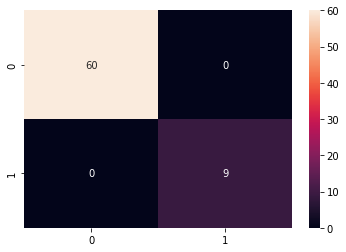

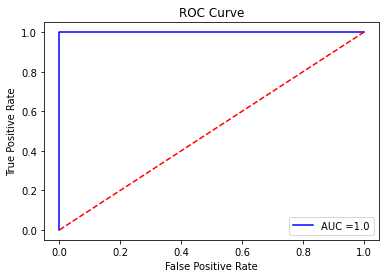

Test Set


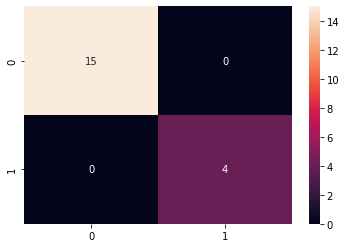

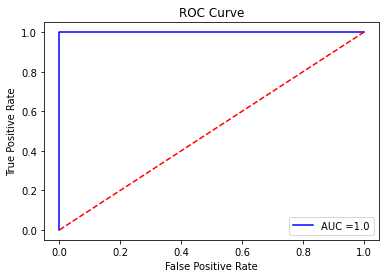

In [279]:
opti_L(1,'liblinear',True,True,False,False)

Both L1-penalized and variable selection using p-values have score of 1 for certain L values. In the case of L-1 penalized it was at L=1 and in the other one it was at L=13. For optimal L I chose the smallest L that has a train score of 1.
The test scores for optimal L was also 1 for optimal L values that I chose. 
That is the model is able to identify all TPs and TNs.

Bariable selection using p-values, it's a 2step process, implement RFECV, selct significant features then calculate the f1 score and the train score was 1 was at higher l values so required more computation too.
However, in l1-penalized parameter selection is automatically done.
Overall,The l1-penalized was easier to implement. 


# Multi-class Classification (The Realistic Case)


In [280]:
reqd_stats = ['min', 'max', 'mean', 'median', 'std','1st_quart','3rd_quart']
n=20

get_LR_L1_penalized(reqd_stats,n,'saga',True,False,False,False)


l 	 Train accuracy 	 Test Accuracy
1 0.927536231884058 0.7368421052631579
2 0.9565217391304348 0.7894736842105263
3 1.0 0.7368421052631579
4 1.0 0.7894736842105263
5 1.0 0.8421052631578947
6 1.0 0.6842105263157895
7 1.0 0.631578947368421
8 1.0 0.7368421052631579
9 1.0 0.7368421052631579
10 0.9855072463768116 0.7894736842105263
11 1.0 0.6842105263157895
12 1.0 0.631578947368421
13 1.0 0.7368421052631579
14 1.0 0.7368421052631579
15 1.0 0.7368421052631579
16 1.0 0.631578947368421
17 1.0 0.6842105263157895
18 1.0 0.6842105263157895
19 1.0 0.6842105263157895
20 1.0 0.7368421052631579
     l  Train Score  Test Score
0    1     0.927536    0.736842
1    2     0.956522    0.789474
2    3     1.000000    0.736842
3    4     1.000000    0.789474
4    5     1.000000    0.842105
5    6     1.000000    0.684211
6    7     1.000000    0.631579
7    8     1.000000    0.736842
8    9     1.000000    0.736842
9   10     0.985507    0.789474
10  11     1.000000    0.684211
11  12     1.000000    0.6315

The optimal L value observed is 5 since train score is 1 and test score is maximum (0.84)

Training Set


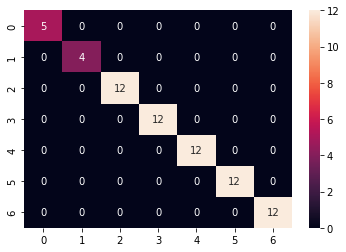

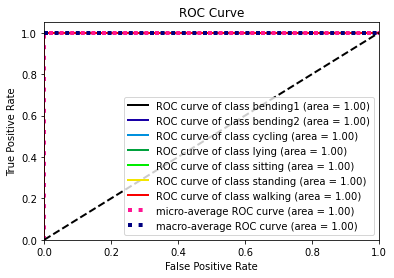

Test Set


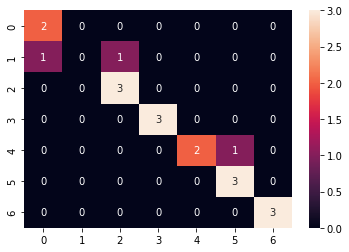

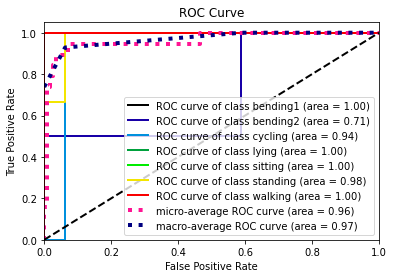

In [281]:
opti_L(5,'saga',True,False,False,False)

# Using a  Na¨ıve Bayes’ classifier. Using botj Gaussian and Multinomial priors and comparing the results.

In [282]:
#Gaussian

reqd_stats = ['min', 'max', 'mean', 'median', 'std','1st_quart','3rd_quart']
n=20
print("Gaussian")
get_LR_L1_penalized(reqd_stats,n,'saga',False,False,True,False)

Gaussian
l 	 Train accuracy 	 Test Accuracy
1 0.9420289855072463 0.7368421052631579
2 0.9565217391304348 0.6842105263157895
3 0.9855072463768116 0.7368421052631579
4 0.9710144927536232 0.7894736842105263
5 0.9855072463768116 0.8421052631578947
6 0.9565217391304348 0.5263157894736842
7 0.9565217391304348 0.7894736842105263
8 0.9565217391304348 0.6842105263157895
9 0.9855072463768116 0.6842105263157895
10 1.0 0.7368421052631579
11 1.0 0.7368421052631579
12 1.0 0.6842105263157895
13 1.0 0.5789473684210527
14 1.0 0.6842105263157895
15 1.0 0.5263157894736842
16 1.0 0.5789473684210527
17 1.0 0.5263157894736842
18 1.0 0.5263157894736842
19 1.0 0.631578947368421
20 1.0 0.5263157894736842
     l  Train Score  Test Score
0    1     0.942029    0.736842
1    2     0.956522    0.684211
2    3     0.985507    0.736842
3    4     0.971014    0.789474
4    5     0.985507    0.842105
5    6     0.956522    0.526316
6    7     0.956522    0.789474
7    8     0.956522    0.684211
8    9     0.985507    

The optimal L value observed is 9 since train score is 1 and test score is maximum (0.74)

Training Set


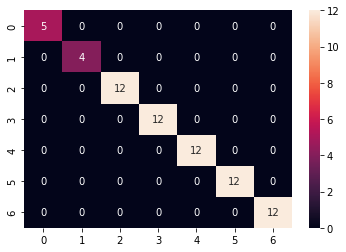

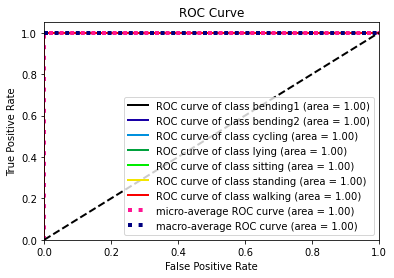

Test Set


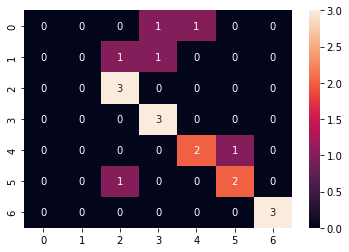

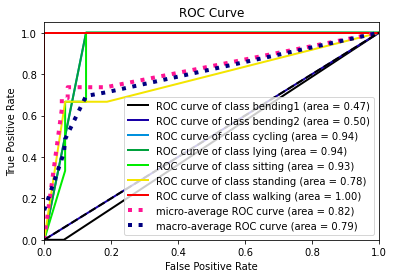

In [283]:
opti_L(9,'saga',False,False,True,False)

In [284]:
#Naive Bayes
reqd_stats = ['min', 'max', 'mean', 'median', 'std','1st_quart','3rd_quart']
n=20
print("Naive Bayes Multinomial Priors")
get_LR_L1_penalized(reqd_stats,n,'saga',False,False,False,True)


Naive Bayes Multinomial Priors
l 	 Train accuracy 	 Test Accuracy
1 0.8405797101449275 0.7368421052631579
2 0.8115942028985508 0.7368421052631579
3 0.855072463768116 0.6842105263157895
4 0.855072463768116 0.7894736842105263
5 0.8985507246376812 0.7894736842105263
6 0.8985507246376812 0.6842105263157895
7 0.8695652173913043 0.7368421052631579
8 0.8985507246376812 0.6842105263157895
9 0.8985507246376812 0.6842105263157895
10 0.927536231884058 0.7368421052631579
11 0.927536231884058 0.6842105263157895
12 0.927536231884058 0.6842105263157895
13 0.927536231884058 0.6842105263157895
14 0.9565217391304348 0.6842105263157895
15 0.9420289855072463 0.6842105263157895
16 0.9420289855072463 0.6842105263157895
17 0.9420289855072463 0.6842105263157895
18 0.9420289855072463 0.6842105263157895
19 0.9420289855072463 0.6842105263157895
20 0.9420289855072463 0.6842105263157895
     l  Train Score  Test Score
0    1     0.840580    0.736842
1    2     0.811594    0.736842
2    3     0.855072    0.684211
3

The optimal L value observed is 4 since train score is 0.84 and test score is maximum (0.78)

Training Set


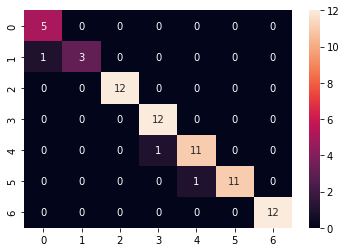

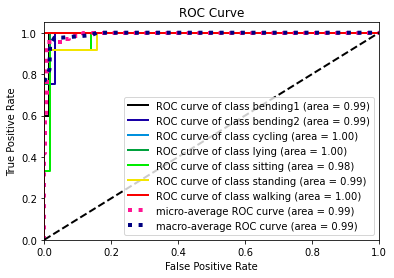

Test Set


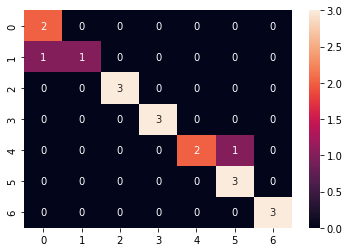

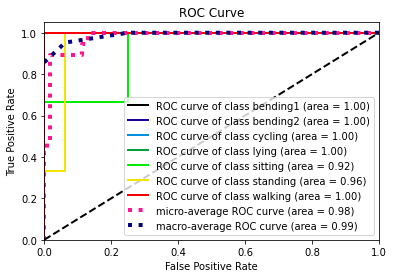

In [285]:
opti_L(4,'saga',False,False,False,True)

Naive bayes with multinomial priors seemed to work the best since the number of mis-classifications for the test set is 
lower than that of gaussian and l-1 penalized. Also, the AUC for all classes is better in Naive Bayes.